In [0]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

In [0]:
!pip install --upgrade pip
!pip3 install torchvision fastai==0.7 torch==0.3.1 torchtext==0.2.3

In [3]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline
!pwd

/content


In [4]:
import subprocess, os
os.uname()

posix.uname_result(sysname='Linux', nodename='54c7ac56ac31', release='4.14.33+', version='#1 SMP Wed Jun 20 01:36:48 PDT 2018', machine='x86_64')

In [5]:
from fastai.conv_learner import *
!pip3 show fastai torch torchtext | grep Name -A 1

Name: fastai
Version: 0.7.0
--
Name: torch
Version: 0.3.1
--
Name: torchtext
Version: 0.2.3


In [0]:
#from fastai.imports import *
#from fastai.transforms import *
#from fastai.conv_learner import *
#from fastai.model import *
#from fastai.dataset import *
#from fastai.sgdr import *
#from fastai.plots import *
#!pip3 show fastai torch | grep Name -A 1

In [7]:
torch.cuda.set_device(0)
torch.cuda.get_device_name(0)

'Tesla K80'

---
# Fast Ai
---
http://course.fast.ai/start.html



---


2 способа размечивания данных для обучения:
- по каталогам
- по csv файлу


---



### Загрузка датасета "Кошки и собаки"
Разметка по каталогам

In [0]:
!wget http://files.fast.ai/data/dogscats.zip
!unzip dogscats.zip

In [9]:
PATH = "dogscats/"
os.listdir(PATH)

['valid', 'train', 'sample', 'models', 'test1']

In [10]:
CLASSES = os.listdir(f'{PATH}train/')
CLASSES

['cats', 'dogs']

In [11]:
train_dogs = os.listdir(f'{PATH}train/{CLASSES[0]}')
train_dogs[:10]

['cat.10233.jpg',
 'cat.9757.jpg',
 'cat.2503.jpg',
 'cat.10099.jpg',
 'cat.8871.jpg',
 'cat.7679.jpg',
 'cat.3433.jpg',
 'cat.5359.jpg',
 'cat.75.jpg',
 'cat.8108.jpg']

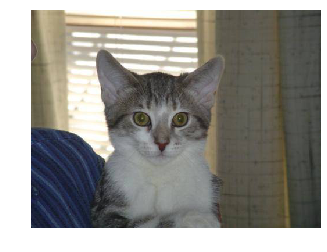

In [12]:
train_dogs_img_0 = plt.imread(f'{PATH}train/{CLASSES[0]}/{train_dogs[0]}')
plt.imshow(train_dogs_img_0)
plt.axis('off')
plt.show()

In [13]:
train_dogs_img_0.shape

(375, 499, 3)

In [14]:
train_dogs_img_0[:4][:2]

array([[[102,  89,  70],
        [ 99,  87,  65],
        [ 96,  84,  62],
        ...,
        [ 64,  66,  63],
        [ 60,  62,  59],
        [ 57,  59,  56]],

       [[102,  89,  70],
        [ 99,  87,  65],
        [ 96,  84,  62],
        ...,
        [ 65,  67,  64],
        [ 62,  64,  61],
        [ 58,  60,  57]]], dtype=uint8)

### Сбросить предварительно вычисленные активации

Нейросеть создаётся из загруженной обученной модели с добавлением пары новых выходных слоёв.

Делится на три части: свёрточная, активационная, наша добавленная.

**precompute=False** отключает предвычисленные активации

**learn.unfreeze()** размораживает всё

In [0]:
## Это fastai аналог метода выключить-включить
#def tmp_clear():
#  shutil.rmtree(f'{PATH}tmp', ignore_errors=True)
#  print(f'"{PATH}tmp/" empty')
#
#tmp_clear()

### Нейросеть ResNet34

In [0]:
sz = 224 # размер обрезки фотографий

In [0]:
# Архитектура нейросети
arch = resnet34 # https://download.pytorch.org/models/resnet34-333f7ec4.pth
#arch = resnet50 # https://download.pytorch.org/models/resnet50-19c8e357.pth

In [22]:
# Подготовка данных (дополнение, сведение размера, обрезке, нормализации)
# aug_tfms (augmentation transforms) - включить дополнения данных 
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.2)
tfms

([<fastai.transforms.RandomScale object at 0x7f24aa006668>, <fastai.transforms.RandomRotate object at 0x7f24aa246fd0>, <fastai.transforms.RandomLighting object at 0x7f24aa255080>, <fastai.transforms.RandomFlip object at 0x7f24aa2550b8>, <fastai.transforms.RandomCrop object at 0x7f24aa0066d8>, <fastai.transforms.Normalize object at 0x7f24aa0064e0>, <fastai.transforms.ChannelOrder object at 0x7f24aa006710>],
 [<fastai.transforms.Scale object at 0x7f24aa006588>, <fastai.transforms.CenterCrop object at 0x7f24aa0065f8>, <fastai.transforms.Normalize object at 0x7f24aa0064e0>, <fastai.transforms.ChannelOrder object at 0x7f24aa006630>])

In [23]:
# Организация набора данных для обучения
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
data

In [24]:
# Подготовка нейросети классификатора двух объектов (заменяется последний слой)
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn # показывает добавленные слои для полученной модели

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /content/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 56796924.32it/s]


100%|██████████| 32/32 [00:14<00:00,  2.21it/s]


Sequential(
  (0): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True)
  (1): Dropout(p=0.25)
  (2): Linear(in_features=1024, out_features=512, bias=True)
  (3): ReLU()
  (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True)
  (5): Dropout(p=0.5)
  (6): Linear(in_features=512, out_features=2, bias=True)
  (7): LogSoftmax()
)

### Дополнение данных

In [0]:
# Функция для визуализации вариантов дополнения
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [0]:
# Пакет изображений вариантов
ims = np.stack([get_augs() for i in range(6)])

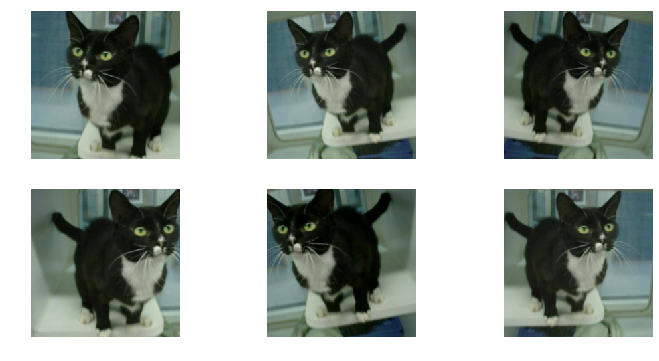

In [29]:
from fastai.plots import *
plots(ims, rows=2)

### Нахождение оптимальной скорости обучения

In [30]:
# Вычисление скоростей обучения
learn.lr_find()

 81%|████████  | 290/360 [00:06<00:01, 44.08it/s, loss=0.425]


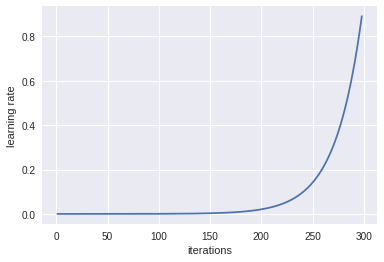

In [31]:
learn.sched.plot_lr()

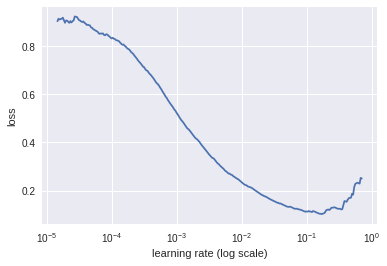

In [32]:
learn.sched.plot() # подбирается по максимальному уклону графика потерь (loss)

In [0]:
# Скорость обучение берётся на порядок меньшим значения, слегка левей самой низкой точки графика

### Обучение

In [33]:
# Обучение с подобранной скоростью обучения (данные в папке train)
# 1e-2 - подобранная скорость обучения (0.01)
# 1 - количество циклов (не эпох)
learn.fit(1e-2, 1)

epoch      trn_loss   val_loss   accuracy   
    0      0.050665   0.029677   0.9905    



[array([0.02968]), 0.9905]

In [34]:
data.val_y #  метки классов

array([0, 0, 0, ..., 1, 1, 1])

In [35]:
data.classes # классы

['cats', 'dogs']

In [0]:
# Дополнение данных не работает с предвычисленными активациями
# Для получения своих активаций, используем precompute=False
learn.precompute = False

In [37]:
# Снова обучаем, уже без предвычисленных активаций
# Указанная скорость обучении (0.01) - максимальная скорость перед автоматическим снижением
# cycle_len=1 - за сколько циклов автоматически уменьшается скорость обучения
# общее количество эпох = количество циклов * cycle_len
learn.fit(0.01, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      0.044612   0.028194   0.989     
 51%|█████     | 184/360 [01:38<01:34,  1.87it/s, loss=0.0532]

    1      0.039039   0.029376   0.9905    
    2      0.040452   0.026179   0.9905    



[array([0.02618]), 0.9905]

In [0]:
# 2      0.040452   0.026179   0.9905
# 2 - номер эпохи
# левое число - ошибки (потери (loss)) на обучающей выборке
# среднее число - ошибки на тестовой выборке
# правое число - точность предсказывания (метрика)
# Если валидационные ошибки больше тестовых - имеем переобучение
# Точность (потери, ошибки) - это отношение правильных прогнозов к их общему числу

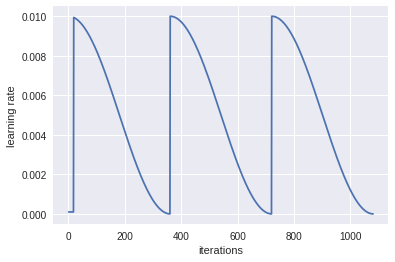

In [39]:
# График изменения скорости обучения
# Видим как работает метод SGDR
learn.sched.plot_lr()

In [0]:
# Разморозка слоёв
learn.unfreeze() # разморозка всех слоёв
#learn.unfreeze_to(n) # разморозка всех слоёв до n-ного
learn.bn_freeze(True) # фиксирует нормализацию минибатчей

In [0]:
# Дифференциальная скорость обучения
# Сейчас используется нейросеть с 3 группами слоёв
# Последний слой с такой же скоростью, каждый предыдущий - на порядок меньше
lr=np.array([1e-4, 1e-3, 1e-2])

In [0]:
# Дообучаем с размороженными слоями
# cycle_mult=2 - во сколько раз увеличивать cycle_len после каждого цикла
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

In [0]:
learn.sched.plot_lr()

In [40]:
# Метод TTA прогнозирования (test time augmentation)

# TTA просто делает прогнозы не только на изображениях в вашем наборе проверки, 
# но и делает прогнозы на ряде случайно дополненных версий из них тоже (по умолчанию, 
# он использует исходное изображение вместе с 4 случайно дополненных версий). 
# Затем он берет среднее предсказание из этих изображений и использует это. 
# Чтобы использовать это в наборе проверки, мы можем использовать метод TTA.

log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [42]:
# Точность (метрика)
accuracy_np(probs, y)

0.9935

## Алгоритм обуения
**1. precompute=True**

**2. Использовать lr_find (), найти оптимальную скорость обучения**

**3. Обучить последний слой из предварительно вычисленных активаций для 1-2 эпохи**

**4. Обучить с увеличением данных (т. е. precompute=False) 2-3 эпохи с cycle_len=1**

**5. Разморозить все слои (learn.unfreeze())**

**6. Установите более ранние слои в 10 (3) раз более низкую скорость обучения, чем каждый следующий  слой**

**7. Используйте lr_find() снова**

**8. Обучение полной сети с cycle_mult=2 до появления признаков переобучения**

**Матрица ошибок**

In [0]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [0]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[994   6]
 [  7 993]]


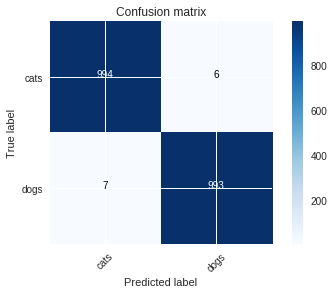

In [45]:
plot_confusion_matrix(cm, data.classes)

### Проверка

In [46]:
# Прогнозирование для набора проверки (в папке valid)
log_preds = learn.predict() # - без TTA !
log_preds.shape

(2000, 2)

In [47]:
# Результаты прогнозирования по всем классам в одном массиве
log_preds[-10:] # последние десять

array([[ -8.34746,  -0.00024],
       [ -6.77454,  -0.00114],
       [ -8.11256,  -0.0003 ],
       [-12.4203 ,  -0.     ],
       [ -0.03266,  -3.43782],
       [ -1.42151,  -0.27621],
       [ -8.92104,  -0.00013],
       [ -8.43595,  -0.00022],
       [ -8.39631,  -0.00023],
       [ -1.09788,  -0.40583]], dtype=float32)

In [48]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)
print(preds,probs)

[0 0 0 ... 1 1 1] [0.0001  0.00004 0.00013 ... 0.99978 0.99977 0.66642]


In [0]:
# Вспомогательные функции для проверок
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

In [0]:
# Функции выборки изображений для проверок
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]
def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Правильно распознано


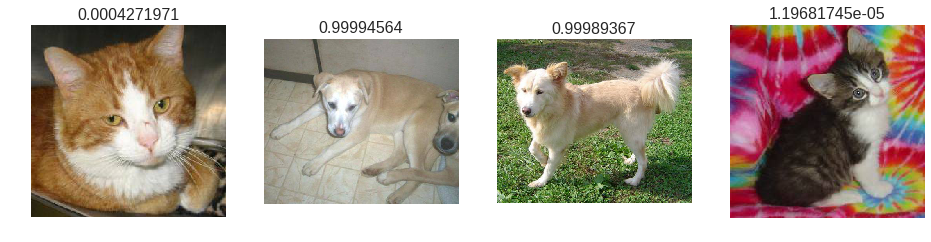

In [51]:
plot_val_with_title(rand_by_correct(True), 'Правильно распознано')

Неправильно распознано


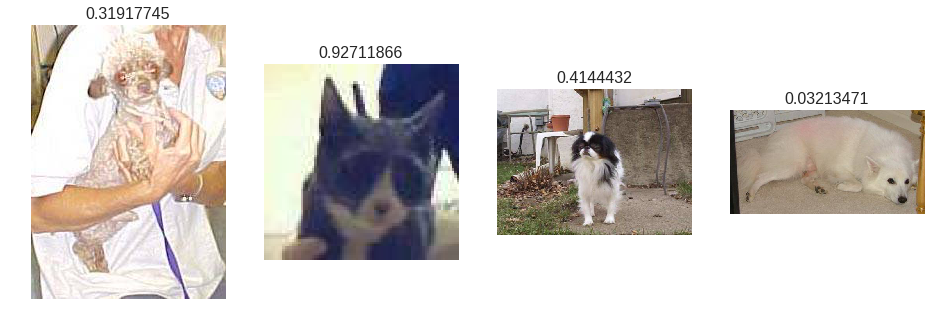

In [52]:
plot_val_with_title(rand_by_correct(False), 'Неправильно распознано')

Самые правильные кошки


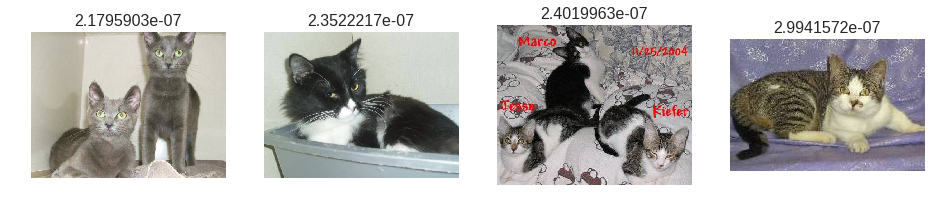

In [53]:
plot_val_with_title(most_by_correct(0, True), 'Самые правильные кошки')

Самые правильные собаки


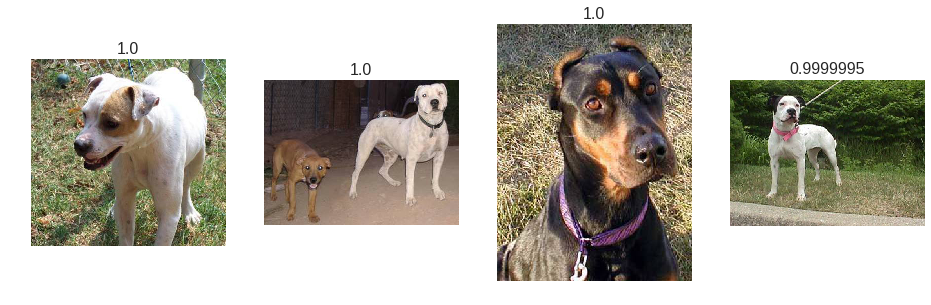

In [54]:

plot_val_with_title(most_by_correct(1, True), 'Самые правильные собаки')

Самые неправильные кошки


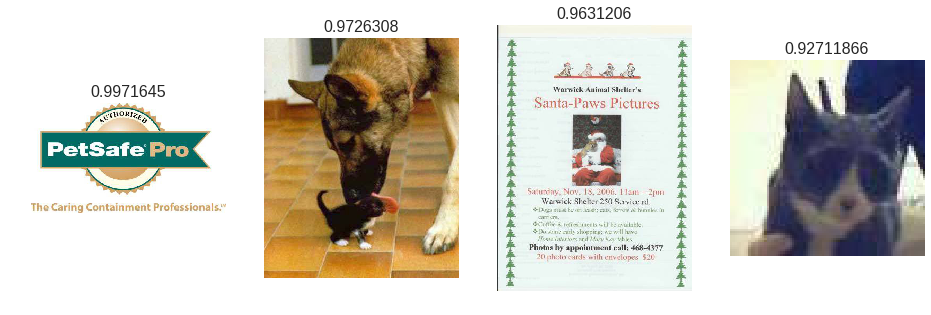

In [55]:
plot_val_with_title(most_by_correct(0, False), 'Самые неправильные кошки')

Самые неправильные собаки


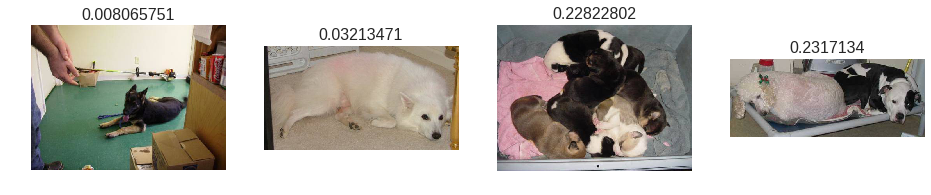

In [56]:
plot_val_with_title(most_by_correct(1, False), 'Самые неправильные собаки')

Самые неопределенные прогнозы


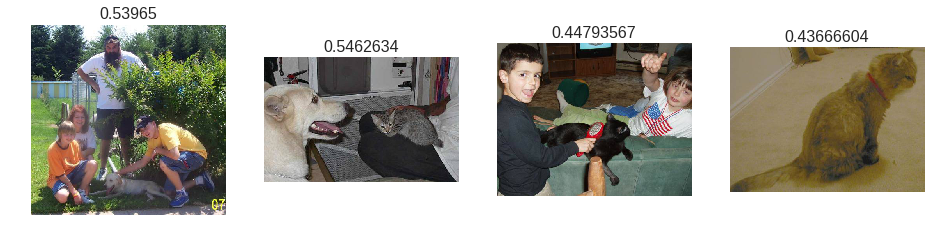

In [57]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, 'Самые неопределенные прогнозы')

### Сохранение и загрузка

In [58]:
# Промежутоные файлы, предвычисленные активации, обрезанные изображения
os.listdir(f'{PATH}tmp')

['x_act_val_resnet34_0_224.bc',
 'x_act_test_resnet34_0_224.bc',
 'x_act_resnet34_0_224.bc']

In [59]:
# Сохранение весов
learn.save('model_probe_1')
os.listdir(f'{PATH}models')

['model_probe_1.h5', 'tmp.h5']

In [0]:
# Загрузка весов
learn.load('model_probe_1')

.



---



### Загрузка датасета "120 пород собак"
Разметка по csv файлу

In [0]:
# Датасет находится по адресу:
# https://www.kaggle.com/c/dog-breed-identification/data

In [0]:
# Для получения данных из kaggle нужно быть зарегистрированным на сайте kaggle.com
# а так же в профиле включить АПИ и скачать ключ, в профиле: 'Create API Token' 
# Модуль API Kaggle
!pip3 install kaggle

In [0]:
# Предварительно нужно закачать ключ 'kaggle.json'
# Подробней об АПИ kaggle здесь: https://github.com/Kaggle/kaggle-api
from google.colab import files
files.upload()

In [63]:
# Переместим kaggle.json в нужный каталог
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [64]:
# Скачаем необходимый датасет
!kaggle competitions download -c dog-breed-identification

  0%|                                                | 0.00/214k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 214k/214k [00:00<00:00, 24.2MB/s]
  0%|                                                | 0.00/318k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 318k/318k [00:00<00:00, 76.4MB/s]
 98%|███████████████████████████████████████ | 338M/346M [00:03<00:00, 90.8MB/s]
100%|████████████████████████████████████████| 346M/346M [00:03<00:00, 94.8MB/s]
 99%|███████████████████████████████████████▍| 340M/345M [00:04<00:00, 97.5MB/s]
100%|████████████████████████████████████████| 345M/345M [00:04<00:00, 89.2MB/s]


In [65]:
!ls .kaggle/competitions/dog-breed-identification

labels.csv.zip	sample_submission.csv.zip  test.zip  train.zip


In [0]:
# Распакуем датасет
!unzip ~/.kaggle/competitions/dog-breed-identification/labels.csv.zip -d ~
!unzip ~/.kaggle/competitions/dog-breed-identification/sample_submission.csv.zip -d ~
!unzip ~/.kaggle/competitions/dog-breed-identification/test.zip -d ~
!unzip ~/.kaggle/competitions/dog-breed-identification/train.zip -d ~

In [68]:
# labels.csv - файл разметки данных
# sample_submission.csv
# test - каталог тестового набора
# train - каталог обучающего набора
!ls

datalab   dogscats.zip	lr_plot.png	       test
dogscats  labels.csv	sample_submission.csv  train


### Подготовка нейросети

In [69]:
# Каталог данных
PATH = ''
PATH

''

In [70]:
# Архитектура нейронной сети
arch = resnext101_64
arch

<function fastai.torch_imports.resnext101_64>

In [0]:
# Размер (ширина=высота) для подготовки картинок
sz = 224

In [0]:
# Размер батча (количество картинок)
bs = 58

In [73]:
label_csv = f'{PATH}labels.csv'
n = len(list(open(label_csv))) - 1 # header is not counted (-1)
val_idxs = get_cv_idxs(n) # случайные данные 20% для набора проверки (кросс-валидация)
val_idxs.shape

(2044,)

In [74]:
# Количество картинок
n

10222

In [75]:
# Проверка количества картинок в каталоге train
ls -l train | grep "^-" | wc

  10222   91998  827982


In [76]:
# Количество валидационных картинок
len(val_idxs)

2044

In [77]:
# Чтение файла меток
label_df = pd.read_csv(label_csv)
# Показ первых 5 строк
label_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [78]:
# Сводная таблица расспределения картинок по породам
label_df.pivot_table(index="breed", aggfunc=len).sort_values('id', ascending=False)

,id
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114
shih-tzu,112
great_pyrenees,111
pomeranian,111
basenji,110


In [0]:
# Настройки для обработки картинок
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.2)

In [0]:
# Подготовка картинок (из списка csv файла)
data = ImageClassifierData.from_csv(PATH, # директория с данными
                                    'train', # папка обучающего набора
                                    f'{PATH}labels.csv', # файл меток
                                    test_name='test',  # Вам нужно указать, где находится набор тестов, если вы хотите участвовать в конкурсах Kaggle
                                    val_idxs=val_idxs, # массив индексов валидационного набора
                                    suffix='.jpg', # расширение файлов картинок
                                    tfms=tfms, # дополнения данных
                                    bs=bs) # размер батча

In [81]:
# Имя первой картинки тренировочного набора
file_name = PATH + data.trn_ds.fnames[0]
file_name

'train/001513dfcb2ffafc82cccf4d8bbaba97.jpg'

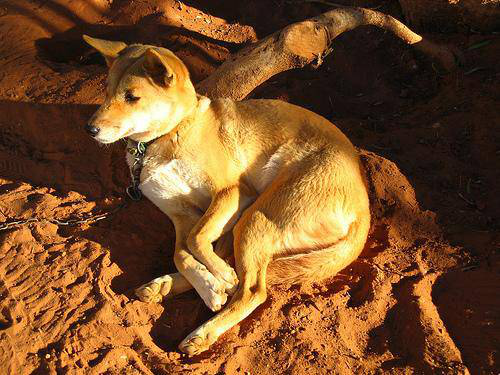

In [82]:
# Отображение первой картинки тренировочного набора
img = PIL.Image.open(file_name)
img

In [83]:
# Размер картинки
img.size

(500, 375)

In [84]:
# Словарь размеров всех картинок
size_d = {k: PIL.Image.open(PATH + k).size for k in data.trn_ds.fnames}
len(size_d)

8178

In [0]:
# Списки ширин и высот картинок (распаковка аргументов)
row_sz, col_sz = list(zip(*size_d.values()))

In [0]:
# Оборачивание в numpy массивы
row_sz = np.array(row_sz)
col_sz = np.array(col_sz)

In [87]:
# Первые 5 ширин
row_sz[:5]

array([500, 500, 500, 500, 500])

(array([3023., 5024.,   92.,   15.,    5.,    3.,   13.,    2.,    0.,    1.]),
 array([  97. ,  413.7,  730.4, 1047.1, 1363.8, 1680.5, 1997.2, 2313.9, 2630.6, 2947.3, 3264. ]),
 <a list of 10 Patch objects>)

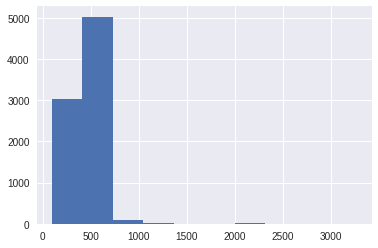

In [88]:
# гистограмма ширин картинок
plt.hist(row_sz)

(array([ 135.,  592., 1347., 1164., 4599.,  128.,   76.,   62.,   14.,   11.]),
 array([ 97. , 185.5, 274. , 362.5, 451. , 539.5, 628. , 716.5, 805. , 893.5, 982. ]),
 <a list of 10 Patch objects>)

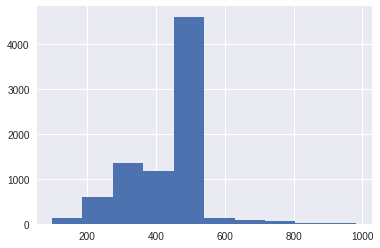

In [89]:
# Ширина меньше 1000
plt.hist(row_sz[row_sz < 1000])

(array([2870., 5121.,  128.,   25.,   10.,   15.,    5.,    2.,    0.,    2.]),
 array([ 102.,  348.,  594.,  840., 1086., 1332., 1578., 1824., 2070., 2316., 2562.]),
 <a list of 10 Patch objects>)

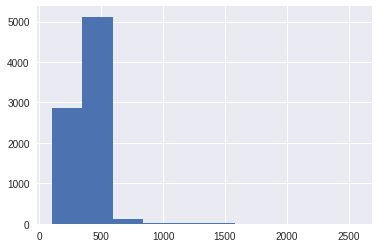

In [90]:
# гистограмма высот картинок
plt.hist(col_sz)

(array([ 361., 1258., 1622., 4630.,  158.,   69.,   15.,   13.,    1.,    7.]),
 array([  97. ,  215.3,  333.6,  451.9,  570.2,  688.5,  806.8,  925.1, 1043.4, 1161.7, 1280. ]),
 <a list of 10 Patch objects>)

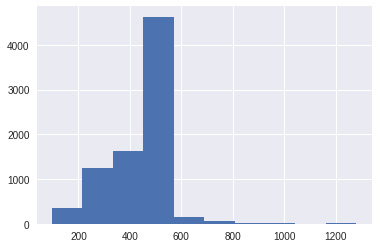

In [91]:
# Высота меньше 1000
plt.hist(row_sz[col_sz < 1000])

In [92]:
# Количество картинок в обучающем и тестовом датасетах
len(data.trn_ds), len(data.test_ds)

(8178, 10357)

In [93]:
len(data.classes), data.classes[:5]

(120,
 ['affenpinscher',
  'afghan_hound',
  'african_hunting_dog',
  'airedale',
  'american_staffordshire_terrier'])

Initial model (Исходная модель)

In [0]:
# Исходная модель

def get_data(sz, bs): # sz: image size, bs: batch size
    tmfs = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', test_name='test',
                                       val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=bs)
    
    # http://forums.fast.ai/t/how-to-train-on-the-full-dataset-using-imageclassifierdata-from-csv/7761/13
    # http://forums.fast.ai/t/how-to-train-on-the-full-dataset-using-imageclassifierdata-from-csv/7761/37
    return data if sz > 300 else data.resize(340, 'tmp') # Reading the jpgs and resizing is slow for big images, so resizing them all to 340 first saves time

#Source:   
#    def resize(self, targ, new_path):
#        new_ds = []
#        dls = [self.trn_dl,self.val_dl,self.fix_dl,self.aug_dl]
#        if self.test_dl: dls += [self.test_dl, self.test_aug_dl]
#        else: dls += [None,None]
#        t = tqdm_notebook(dls)
#        for dl in t: new_ds.append(self.resized(dl, targ, new_path))
#        t.close()
#        return self.__class__(new_ds[0].path, new_ds, self.bs, self.num_workers, self.classes)
#File:      ~/fastai/courses/dl1/fastai/dataset.py

### Нужно скачать мозги для нейронных сетей:

In [95]:
# Узнаём директорию модуля fastai
locat = !pip3 show fastai | grep Location
locat = locat[0].split()[1] + '/fastai'
locat

'/usr/local/lib/python3.6/dist-packages/fastai'

In [96]:
# Скачиваем мозги (весы) моделей нейронок

!wget -O weights.tgz http://files.fast.ai/models/weights.tgz

!tar xvfz weights.tgz -C {locat}

--2018-07-28 06:44:35--  http://files.fast.ai/models/weights.tgz
Resolving files.fast.ai (files.fast.ai)... 67.205.15.147
Connecting to files.fast.ai (files.fast.ai)|67.205.15.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1195411318 (1.1G) [text/plain]
Saving to: ‘weights.tgz’

weights.tgz         100%[===================>]   1.11G  35.7MB/s    in 32s     

2018-07-28 06:45:08 (35.2 MB/s) - ‘weights.tgz’ saved [1195411318/1195411318]

weights/
weights/wrn_50_2f.pth
weights/resnext_101_32x4d.pth
weights/resnext_101_64x4d.pth
weights/inceptionresnetv2-d579a627.pth
weights/inceptionv4-97ef9c30.pth
weights/resnext_50_32x4d.pth


In [97]:
# Проверяем
!ls {locat}/weights

inceptionresnetv2-d579a627.pth	resnext_101_32x4d.pth  resnext_50_32x4d.pth
inceptionv4-97ef9c30.pth	resnext_101_64x4d.pth  wrn_50_2f.pth


### Обучение

In [98]:
# размер картинок и размер батча
sz, bs

(224, 58)

In [99]:
# Создаём данные для обучения
data = get_data(sz, bs)

In [100]:
# Базовая архитектура нейронки
arch

<function fastai.torch_imports.resnext101_64>

In [101]:
# Создаём нейронную сеть
learn = ConvLearner.pretrained(arch, data, precompute=True)

100%|██████████| 179/179 [05:42<00:00,  1.92s/it]


In [102]:
learn

Sequential(
  (0): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True)
  (1): Dropout(p=0.25)
  (2): Linear(in_features=4096, out_features=512, bias=True)
  (3): ReLU()
  (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True)
  (5): Dropout(p=0.5)
  (6): Linear(in_features=512, out_features=120, bias=True)
  (7): LogSoftmax()
)

In [103]:
# Проводим предварительное обучение
learn.fit(1e-2, 5)

epoch      trn_loss   val_loss   accuracy   
    0      0.948999   0.406662   0.89726   
    1      0.426696   0.323304   0.911937  
    2      0.312199   0.273386   0.921233  
 77%|███████▋  | 108/141 [00:03<00:00, 34.50it/s, loss=0.243]

    3      0.232667   0.262817   0.921233  
    4      0.207799   0.259755   0.914873  



[array([0.25975]), 0.9148728035084189]

In [0]:
# Размораживаем активационный слой
learn.precompute = False

In [0]:
# Обучаем с активационным слоем
learn.fit(1e-2, 3, cycle_len=1)

In [106]:
# Сохраняемся
learn.save('224_pre')
learn.load('224_pre')
!ls tmp/340/models/

224_pre.h5


In [107]:
# Увеличиваем размер картинок
learn.set_data(get_data(299, bs))
sz, bs

(224, 58)

In [0]:
# Размораживаем всю нейронку
learn.freeze()
learn.bn_freeze(True) # фиксирует нормализацию минибатчей

In [0]:
# Ещё обучаем
learn.fit(1e-3, 1, cycle_len=1)
#learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2) # 1+2+4 = 7 epochs

In [109]:
# Тестируем
log_preds, y = learn.TTA() # (5, 2044, 120), (2044,)
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y), metrics.log_loss(y, probs)

(0.9266144814090019, 0.2518243224216293)

In [110]:
# Сохраняемся
learn.save('299_pre')
learn.load('299_pre')
!ls tmp/340/models/

224_pre.h5  299_pre.h5


### Прогнозирование обученной модели

In [111]:
# Картинка для расспознования
fn = data.val_ds.fnames[0]
fn

'train/000bec180eb18c7604dcecc8fe0dba07.jpg'

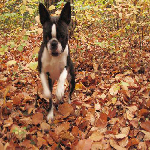

In [112]:
Image.open(PATH + fn).resize((150, 150))

In [113]:
# Метод 1
trn_tfms, val_tfms = tfms_from_model(arch, sz) # дополнение данных (трансформации картинки)
ds = FilesIndexArrayDataset([fn], np.array([0]), val_tfms, PATH)
dl = DataLoader(ds)
preds = learn.predict_dl(dl) # прогнозирование
np.argmax(preds) # формирование единстввенного варианта ответа

19

In [114]:
# Метод 2
trn_tfms, val_tfms = tfms_from_model(arch, sz) # раздельно для тренировочной и валидационной выборок
im = val_tfms(open_image(PATH + fn)) # получение кода картинок в виле numpy.ndarray
preds = learn.predict_array(im[None]) # прогнозирование
# Данные можно передавать в модель (pytorch) и получать от модели только в минибатчах
# Картинка - тензор размерности: (кол-во строк)*(кол-во столбцов)*(цветоввые каналы)
# Минибатч - тензор размерности: (кол-во картинок)*(кол-во строк)*(кол-во столбцов)*(цветоввые каналы)
# Если в numpy индексировать массив im как im[none] - вернётся массив размерностью больше на 1
np.argmax(preds) # формирование единстввенного варианта ответа

19

In [115]:
learn.data.classes[np.argmax(preds)]

'boston_bull'

### Структура нейронной сети resnext101_64

In [116]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 224, 224]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 56, 56]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 56, 